In [128]:
# Initial imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import hvplot.pandas
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Extract Data Frames

In [129]:
def load_data(file_path):
    path = Path(file_path)
    if path.is_file():
        return pd.read_csv(path, encoding='ISO-8859-1')
    else:
        print(f"Error: {file_path} not found.")
        return pd.DataFrame()  # Return empty DataFrame to prevent further errors

# Load datasets
veg_df = load_data('part 1 ETL Workflow/raw_files/Vegetable-Prices-2022.csv')
fru_df = load_data('part 1 ETL Workflow/raw_files/Fruit-Prices-2022.csv')
more_df = load_data('part 1 ETL Workflow/raw_files/pp_national_average_prices_csv.csv')
off_df = load_data('part 1 ETL Workflow/raw_files/hidden_treasures_groceries_gmm.csv')

## Check Naming Convention and Standardize the values

In [130]:
# Check column names in each dataset
print(veg_df.columns)
print(fru_df.columns)
print(more_df.columns)
print(off_df.columns)

Index(['Vegetable', 'Form', 'RetailPrice', 'RetailPriceUnit', 'Yield',
       'CupEquivalentSize', 'CupEquivalentUnit', 'CupEquivalentPrice'],
      dtype='object')
Index(['Fruit', 'Form', 'RetailPrice', 'RetailPriceUnit', 'Yield',
       'CupEquivalentSize', 'CupEquivalentUnit', 'CupEquivalentPrice'],
      dtype='object')
Index(['year', 'food_code', 'mod_code', 'food_description', 'method',
       'method_description', 'nhanes', 'price_100gm'],
      dtype='object')
Index(['Unnamed: 0', 'energy_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'g_sum', 'other_carbs',
       'reconstructed_energy', 'boxcox_carbohydrates_100g',
       'transformed_carbohydrates_100g', 'boxcox_fat_100g',
       'transformed_fat_100g', 'boxcox_proteins_100g',
       'transformed_proteins_100g', 'boxcox_sugars_100g',
       'transformed_sugars_100g', 'boxcox_other_carbs',
       'transformed_other_carbs', 'boxcox_salt_100g', 'transformed_salt_100g',
       'boxco

In [131]:
#Rename columns
veg_df.rename(columns={'Vegetable': 'product'}, inplace=True)
fru_df.rename(columns={'Fruit': 'product'}, inplace=True)
more_df.rename(columns={'food_description': 'product'}, inplace=True)

#keep only relevant columns
veg_df = veg_df[['product', 'RetailPrice']]
fru_df = fru_df[['product', 'RetailPrice']]
more_df = more_df[['product', 'price_100gm']]


In [132]:
inflation_factor = 2
grams_per_pound = 453.592
price_per_100g_to_lb = grams_per_pound / 100

more_df = more_df.assign(
    RetailPrice=more_df['price_100gm'] * inflation_factor * price_per_100g_to_lb
).drop(columns=['price_100gm'])


## Inner Merge on Food Product

In [133]:
#Merge the vegetables on 'product' and fruits on 'product' using an inner join
vegnut_df = pd.merge(veg_df, off_df, on='product', how='inner')
fruitnut_df = pd.merge(fru_df, off_df, on='product', how='inner')
morenut_df = pd.merge(more_df, off_df, on='product', how='inner')

In [134]:
#drop duplicates
vegnut_df.drop_duplicates(subset='product', inplace=True)
fruitnut_df.drop_duplicates(subset='product', inplace=True)
morenut_df.drop_duplicates(subset='product', inplace=True)

In [135]:
vegnut_df.to_csv('part 1 ETL Workflow/merged_files/veg.csv', index=False)
fruitnut_df.to_csv('part 1 ETL Workflow/merged_files/fruit.csv', index=False)
morenut_df.to_csv('part 1 ETL Workflow/merged_files/more.csv', index=False)

# Stack Data Frames

In [136]:
working_df = pd.concat([vegnut_df, fruitnut_df, morenut_df], ignore_index=True)


In [137]:


# Dropping unnecessary columns such as 'Unnamed: 0'
df_cleaned = working_df.drop(columns=['Unnamed: 0'])

# Step 2: Check for missing values
missing_values = df_cleaned.isnull().sum()

# Step 3: Drop rows with missing target values (if any)
df_cleaned = df_cleaned.dropna(subset=['RetailPrice'])


In [138]:


df_cleaned.to_csv('final_working.csv', index=False)

In [139]:
# Load the dataset
df = pd.read_csv('final_working.csv')
df.head()


,product,RetailPrice,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,g_sum,other_carbs,...,boxcox_reconstructed_energy,transformed_reconstructed_energy,boxcox_g_sum,transformed_g_sum,cluster,category,certainty,alternative_cluster,alternative_category,anomaly
0,Artichoke,2.4703,314.0,6.67,3.33,1.67,1.67,0.76200,12.0,1.66,...,-0.263470,-1.033042,-0.290163,-1.195525,4,creams & dips,1.0000,6,strange cluster 6,0
1,Asparagus,2.9531,222.0,3.53,3.53,1.18,2.35,0.14986,10.0,2.35,...,-0.416842,-1.207215,-0.381893,-1.241809,4,creams & dips,0.6441,18,tomato sauce,0
2,Beets,1.1431,167.0,0.00,10.00,2.00,2.00,0.12700,12.0,8.00,...,-0.458748,-1.254806,-0.290163,-1.195525,18,tomato sauce,0.9965,1,beans & peas,0
3,Broccoli,2.3458,121.0,0.00,4.71,2.35,3.53,0.07366,8.0,2.36,...,-0.562940,-1.373130,-0.470604,-1.286569,18,tomato sauce,1.0000,8,yoghurt and milk,0
4,Carrots,1.1979,159.0,0.00,8.97,6.41,1.28,0.19558,10.0,2.56,...,-0.506612,-1.309162,-0.381893,-1.241809,18,tomato sauce,0.9999,8,yoghurt and milk,0


In [195]:
df.columns

Index(['product', 'RetailPrice', 'energy_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'g_sum', 'other_carbs', 'reconstructed_energy',
       'boxcox_carbohydrates_100g', 'transformed_carbohydrates_100g',
       'boxcox_fat_100g', 'transformed_fat_100g', 'boxcox_proteins_100g',
       'transformed_proteins_100g', 'boxcox_sugars_100g',
       'transformed_sugars_100g', 'boxcox_other_carbs',
       'transformed_other_carbs', 'boxcox_salt_100g', 'transformed_salt_100g',
       'boxcox_energy_100g', 'transformed_energy_100g',
       'boxcox_reconstructed_energy', 'transformed_reconstructed_energy',
       'boxcox_g_sum', 'transformed_g_sum', 'cluster', 'category', 'certainty',
       'alternative_cluster', 'alternative_category', 'anomaly'],
      dtype='object')

<Axes: >

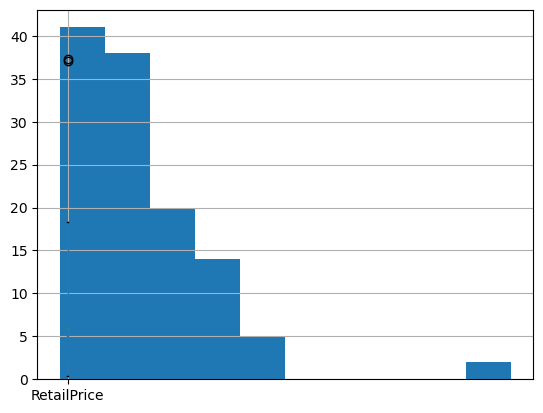

In [141]:
df['RetailPrice'].hist()
df.boxplot(column=['RetailPrice'])

<Axes: xlabel='RetailPrice', ylabel='product'>

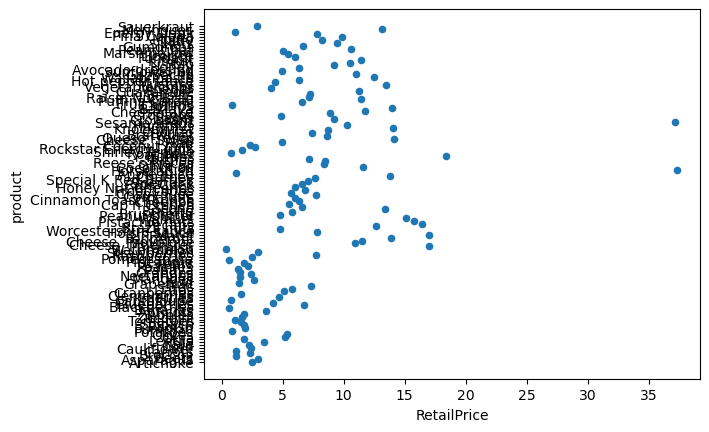

In [142]:
df.plot.scatter(x='RetailPrice', y='product')

In [143]:
# Remove rows where RetailPrice is greater than 30
df_no_outliers = df[df['RetailPrice'] <= 30]

In [186]:
removed_rows = df[df['RetailPrice'] > 30]
print("Rows where RetailPrice is greater than 30 (Removed Rows):")
print(removed_rows)

Rows where RetailPrice is greater than 30 (Removed Rows):
         product  RetailPrice  energy_100g  fat_100g  carbohydrates_100g  \
68   Horseradish    37.341726        418.0       0.0                20.0   
85  Sesame seeds    37.115927       2209.0      41.1                18.0   

    sugars_100g  proteins_100g  salt_100g  g_sum  other_carbs  ...  \
68         10.0            0.0     2.4384   22.0         10.0  ...   
85          2.4           21.6     0.1000   81.0         15.6  ...   

    boxcox_reconstructed_energy  transformed_reconstructed_energy  \
68                    -0.251417                         -1.019354   
85                     1.837018                          1.352347   

    boxcox_g_sum  transformed_g_sum  cluster            category  certainty  \
68      0.203804          -0.946289       12  strange cluster 12        1.0   
85      3.763687           0.849892        0      nuts and seeds        1.0   

    alternative_cluster  alternative_category  anomaly  

<Axes: >

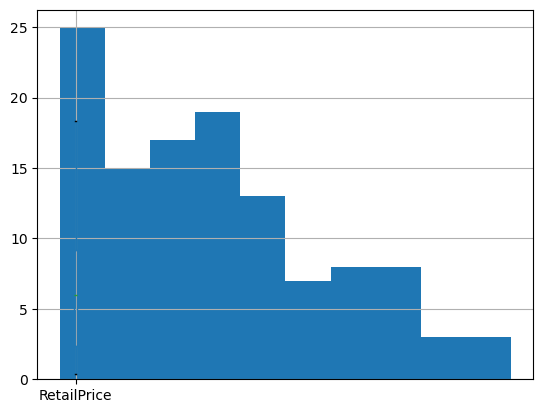

In [144]:
df_no_outliers['RetailPrice'].hist()
df_no_outliers.boxplot(column=['RetailPrice'])

<Axes: xlabel='RetailPrice', ylabel='product'>

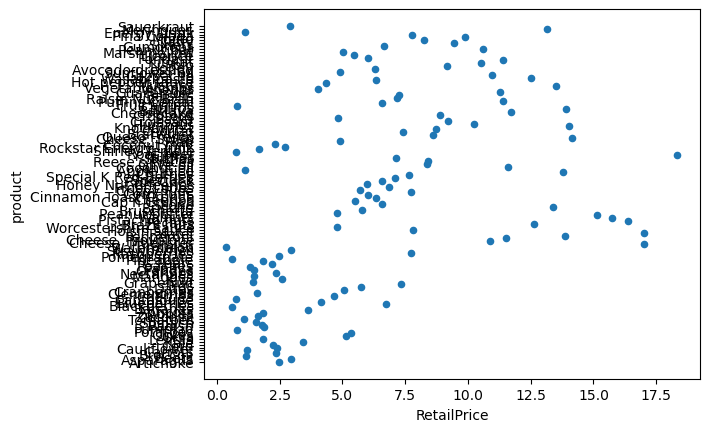

In [145]:
df_no_outliers.plot.scatter(x='RetailPrice', y='product')

The shape of the data is less apparent after taking out the outliers becuase the scatter is more distributed.

In [146]:
#essential columns
features = ["transformed_carbohydrates_100g",
            "transformed_fat_100g",
            "transformed_proteins_100g",
            "transformed_sugars_100g",
            "transformed_salt_100g",
            "transformed_other_carbs",
            "transformed_energy_100g",
            "transformed_reconstructed_energy",
            "transformed_g_sum"]


# reg_features = ["carbohydrates_100g",
#                 "fat_100g",
#                 "proteins_100g",
#                 "sugars_100g",
#                 "salt_100g",
#                 "other_carbs",
#                 "energy_100g",
#                 "reconstructed_energy",
#                 "g_sum"]

target = ['RetailPrice']

#make new data frame with only selected features and price

# features = reg_features

df_essentials = df_no_outliers[features + target]

Correlation Matrix:
                                   transformed_carbohydrates_100g  \
transformed_carbohydrates_100g                          1.000000   
transformed_fat_100g                                   -0.192843   
transformed_proteins_100g                               0.049109   
transformed_sugars_100g                                 0.705840   
transformed_salt_100g                                   0.067773   
transformed_other_carbs                                 0.753766   
transformed_energy_100g                                 0.415267   
transformed_reconstructed_energy                        0.436267   
transformed_g_sum                                       0.735648   

                                  transformed_fat_100g  \
transformed_carbohydrates_100g               -0.192843   
transformed_fat_100g                          1.000000   
transformed_proteins_100g                     0.528445   
transformed_sugars_100g                      -0.277404   
transfor

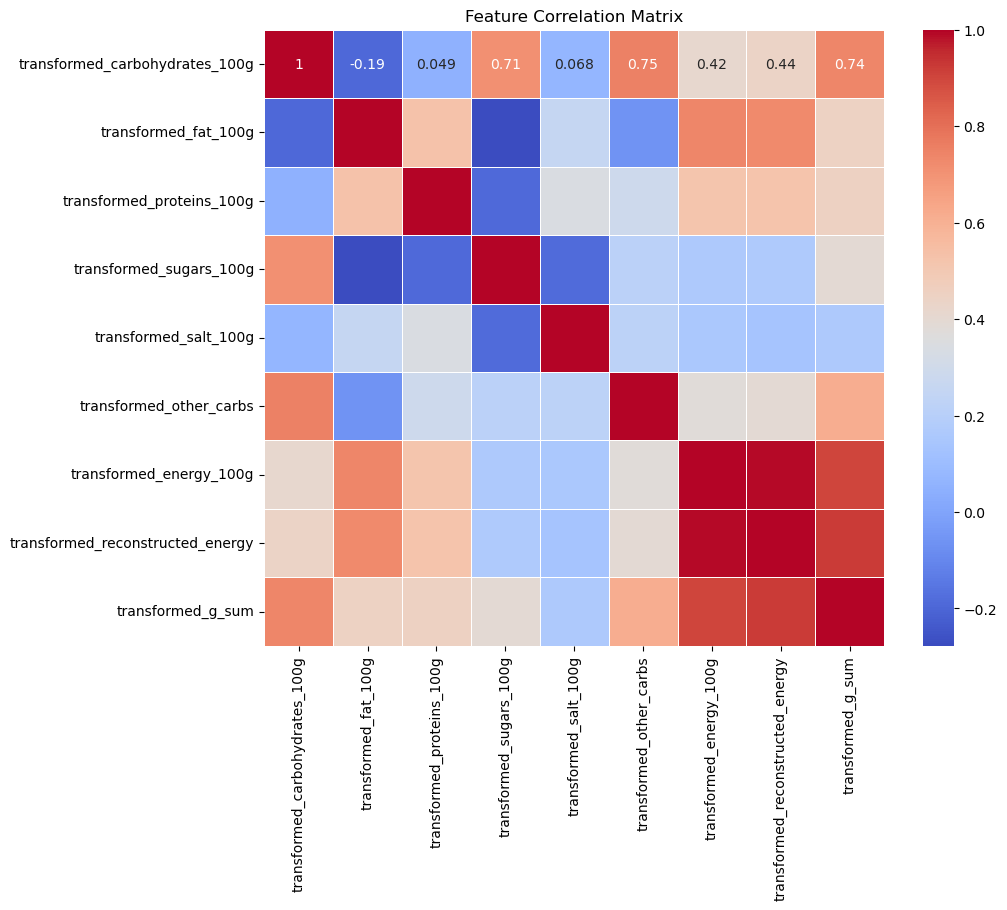

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df[[
    'transformed_carbohydrates_100g', 
    'transformed_fat_100g', 
    'transformed_proteins_100g', 
    'transformed_sugars_100g', 
    'transformed_salt_100g', 
    'transformed_other_carbs', 
    'transformed_energy_100g', 
    'transformed_reconstructed_energy', 
    'transformed_g_sum'
]].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", corr_matrix)

# Optionally visualize the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

**g_sum** represents the rounded sum of the fat-, carbohydrates-, proteins- and salt-values in our data. By doing that we can easily see if there are some products with false entries

**reconstructed_energy** calculates the energy value of a product based on energy values of the features fat, carbohydrates and proteins. We can compare this feature to the amount of energy that is given in our dataset to see if there possibly are some wrong entries.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

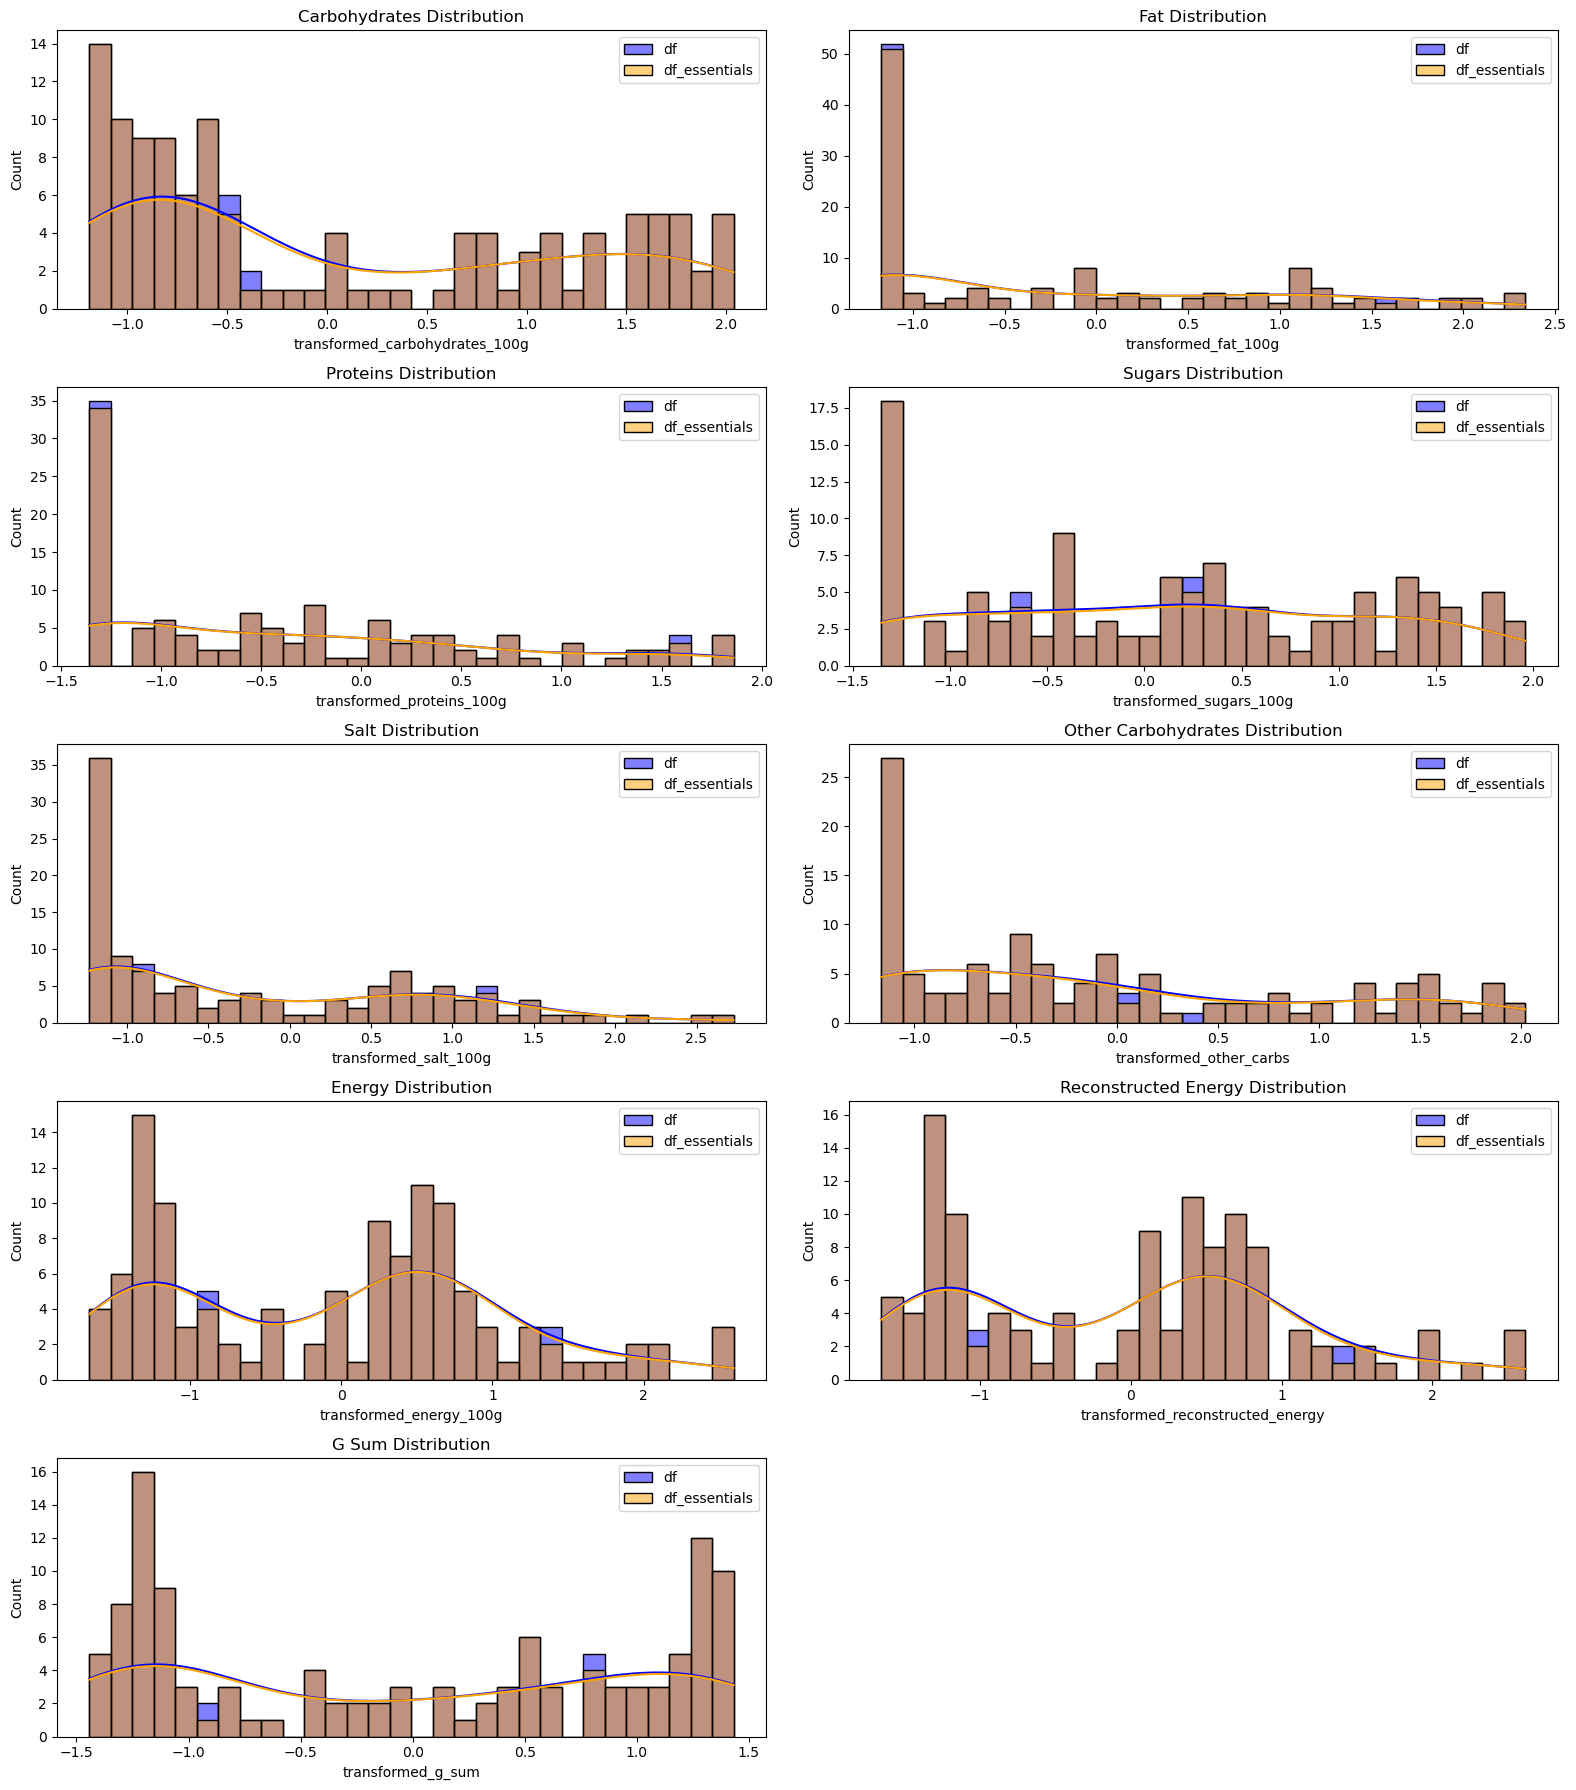

In [147]:
# Set up the figure and axis for subplots (5 rows, 2 columns, to accommodate 9 features)
fig, axes = plt.subplots(5, 2, figsize=(16, 18))

# Histograms of each feature for df and df_essentials side by side
sns.histplot(x='transformed_carbohydrates_100g', data=df, bins=30, ax=axes[0, 0], color='blue', kde=True, label='df')
sns.histplot(x='transformed_carbohydrates_100g', data=df_essentials, bins=30, ax=axes[0, 0], color='orange', kde=True, label='df_essentials')
axes[0, 0].set_title('Carbohydrates Distribution')
axes[0, 0].legend()

sns.histplot(x='transformed_fat_100g', data=df, bins=30, ax=axes[0, 1], color='blue', kde=True, label='df')
sns.histplot(x='transformed_fat_100g', data=df_essentials, bins=30, ax=axes[0, 1], color='orange', kde=True, label='df_essentials')
axes[0, 1].set_title('Fat Distribution')
axes[0, 1].legend()

sns.histplot(x='transformed_proteins_100g', data=df, bins=30, ax=axes[1, 0], color='blue', kde=True, label='df')
sns.histplot(x='transformed_proteins_100g', data=df_essentials, bins=30, ax=axes[1, 0], color='orange', kde=True, label='df_essentials')
axes[1, 0].set_title('Proteins Distribution')
axes[1, 0].legend()

sns.histplot(x='transformed_sugars_100g', data=df, bins=30, ax=axes[1, 1], color='blue', kde=True, label='df')
sns.histplot(x='transformed_sugars_100g', data=df_essentials, bins=30, ax=axes[1, 1], color='orange', kde=True, label='df_essentials')
axes[1, 1].set_title('Sugars Distribution')
axes[1, 1].legend()

sns.histplot(x='transformed_salt_100g', data=df, bins=30, ax=axes[2, 0], color='blue', kde=True, label='df')
sns.histplot(x='transformed_salt_100g', data=df_essentials, bins=30, ax=axes[2, 0], color='orange', kde=True, label='df_essentials')
axes[2, 0].set_title('Salt Distribution')
axes[2, 0].legend()

sns.histplot(x='transformed_other_carbs', data=df, bins=30, ax=axes[2, 1], color='blue', kde=True, label='df')
sns.histplot(x='transformed_other_carbs', data=df_essentials, bins=30, ax=axes[2, 1], color='orange', kde=True, label='df_essentials')
axes[2, 1].set_title('Other Carbohydrates Distribution')
axes[2, 1].legend()

sns.histplot(x='transformed_energy_100g', data=df, bins=30, ax=axes[3, 0], color='blue', kde=True, label='df')
sns.histplot(x='transformed_energy_100g', data=df_essentials, bins=30, ax=axes[3, 0], color='orange', kde=True, label='df_essentials')
axes[3, 0].set_title('Energy Distribution')
axes[3, 0].legend()

sns.histplot(x='transformed_reconstructed_energy', data=df, bins=30, ax=axes[3, 1], color='blue', kde=True, label='df')
sns.histplot(x='transformed_reconstructed_energy', data=df_essentials, bins=30, ax=axes[3, 1], color='orange', kde=True, label='df_essentials')
axes[3, 1].set_title('Reconstructed Energy Distribution')
axes[3, 1].legend()

sns.histplot(x='transformed_g_sum', data=df, bins=30, ax=axes[4, 0], color='blue', kde=True, label='df')
sns.histplot(x='transformed_g_sum', data=df_essentials, bins=30, ax=axes[4, 0], color='orange', kde=True, label='df_essentials')
axes[4, 0].set_title('G Sum Distribution')
axes[4, 0].legend()

# Hide the last unused subplot
axes[4, 1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

In [148]:
# Calculate the mean of each feature in df
df_mean = df[features].mean(numeric_only=True)
print("Averages of features in df:\n", df_mean)

# Calculate the mean of each feature in df_essentials
df_essentials_mean = df_essentials[features].mean(numeric_only=True)
print("\nAverages of features in df_essentials:\n", df_essentials_mean)

Averages of features in df:
 transformed_carbohydrates_100g      0.041203
transformed_fat_100g               -0.184333
transformed_proteins_100g          -0.346366
transformed_sugars_100g             0.132937
transformed_salt_100g              -0.207586
transformed_other_carbs            -0.070118
transformed_energy_100g            -0.039228
transformed_reconstructed_energy   -0.032001
transformed_g_sum                  -0.024871
dtype: float64

Averages of features in df_essentials:
 transformed_carbohydrates_100g      0.049034
transformed_fat_100g               -0.190739
transformed_proteins_100g          -0.354148
transformed_sugars_100g             0.138058
transformed_salt_100g              -0.214761
transformed_other_carbs            -0.075255
transformed_energy_100g            -0.044032
transformed_reconstructed_energy   -0.035365
transformed_g_sum                  -0.024476
dtype: float64


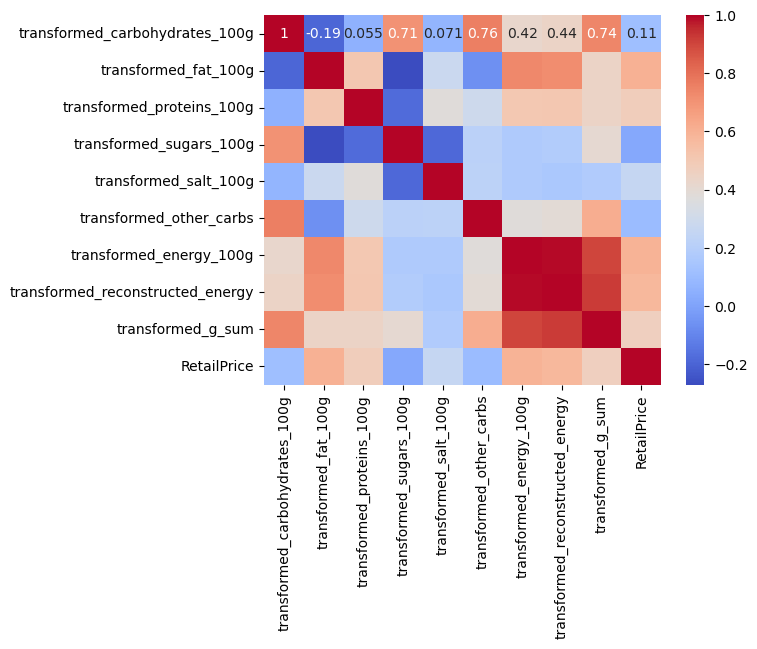

In [149]:
sns.heatmap(df_essentials.corr(), annot=True, cmap='coolwarm')
plt.show()

Retail Price has the least correlation between all the features.  Being able to predict the price based on features may be difficult.  The Transformed reconstructed energy and transformed g sum are highly positively correlated and may overfit the model.

**Multicollinearity** Reduces Model Accuracy: The high VIF values, particularly for transformed_reconstructed_energy, transformed_g_sum, and transformed_energy_100g, suggest that these features carry overlapping information. The model can’t determine the individual contribution of these features effectively, which reduces the overall explanatory power (reflected in the moderate R-squared values)

	**Ridge Regularization** Helps, but Doesn’t Eliminate the Problem: Ridge regression helps reduce the impact of multicollinearity by shrinking coefficients, but with VIF values as high as these, it’s still difficult for the model to generalize well. This explains why you’re getting a moderate R-squared despite using regularization.

# Model Data

In [150]:
# Prepare the data for training
line_X = df_essentials[features]
line_y = df_essentials[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(line_X, line_y, test_size=0.2, random_state=42)

## Linear Regression

In [151]:
# Create and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
line_y_pred = linear_model.predict(X_test)

# Calculate performance metrics
line_mse = mean_squared_error(y_test, line_y_pred)
line_r2 = r2_score(y_test, line_y_pred)

# Display the coefficients, MSE, and R-squared value
line_coefficients = linear_model.coef_
line_intercept = linear_model.intercept_

print("Mean Squared Error:", line_mse)
print("R-squared:", line_r2)

line_coefficients, line_intercept

Mean Squared Error: 12.495409510694495
R-squared: 0.43026604968281645


(array([[ 4.39742289,  1.306242  ,  1.38420076, -0.15669228,  0.42726292,
         -0.77221426,  3.26476944,  3.50819228, -8.82268856]]),
 array([7.23804863]))

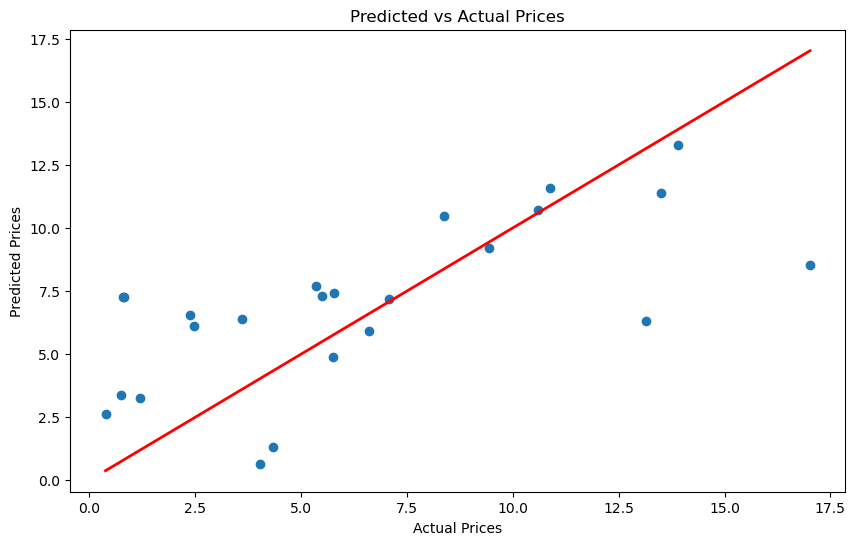

In [152]:
# Create a scatter plot for predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, line_y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

 Linear regression assumes linear relationships, no multicollinearity, homoscedasticity, etc. 

# Inspection: How Features add up to Retail Price

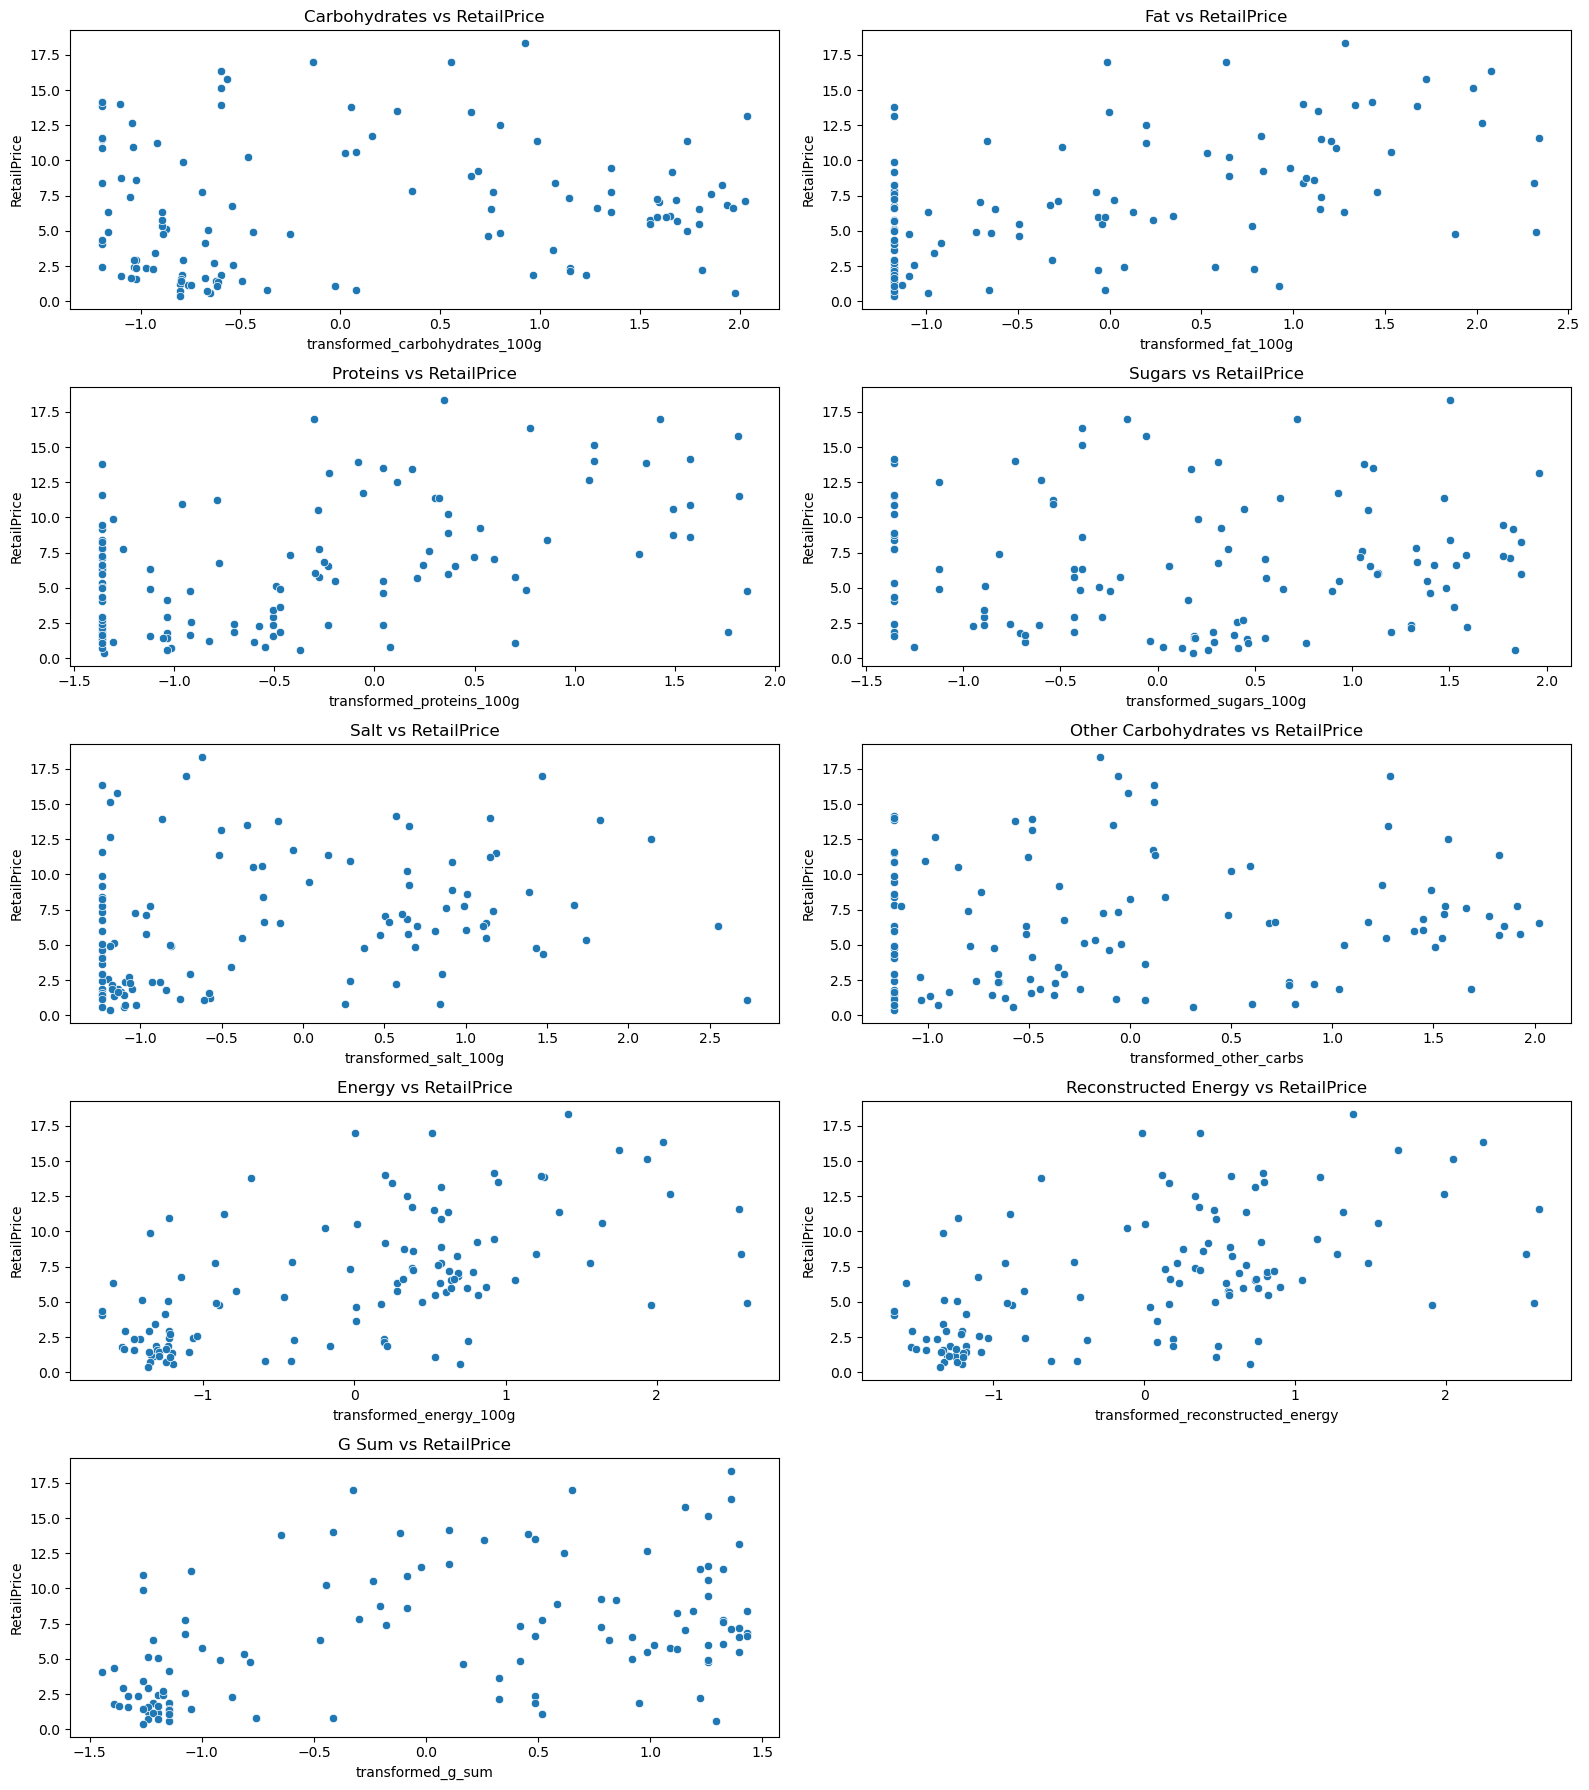

In [153]:
# Set up the figure and axis for subplots (4 rows, 2 columns, to accommodate 9 features)
fig, axes = plt.subplots(5, 2, figsize=(16, 18))

# Scatter plots of each feature vs RetailPrice
sns.scatterplot(x='transformed_carbohydrates_100g', y='RetailPrice', data=df_essentials, ax=axes[0, 0])
axes[0, 0].set_title('Carbohydrates vs RetailPrice')

sns.scatterplot(x='transformed_fat_100g', y='RetailPrice', data=df_essentials, ax=axes[0, 1])
axes[0, 1].set_title('Fat vs RetailPrice')

sns.scatterplot(x='transformed_proteins_100g', y='RetailPrice', data=df_essentials, ax=axes[1, 0])
axes[1, 0].set_title('Proteins vs RetailPrice')

sns.scatterplot(x='transformed_sugars_100g', y='RetailPrice', data=df_essentials, ax=axes[1, 1])
axes[1, 1].set_title('Sugars vs RetailPrice')

sns.scatterplot(x='transformed_salt_100g', y='RetailPrice', data=df_essentials, ax=axes[2, 0])
axes[2, 0].set_title('Salt vs RetailPrice')

sns.scatterplot(x='transformed_other_carbs', y='RetailPrice', data=df_essentials, ax=axes[2, 1])
axes[2, 1].set_title('Other Carbohydrates vs RetailPrice')

sns.scatterplot(x='transformed_energy_100g', y='RetailPrice', data=df_essentials, ax=axes[3, 0])
axes[3, 0].set_title('Energy vs RetailPrice')

sns.scatterplot(x='transformed_reconstructed_energy', y='RetailPrice', data=df_essentials, ax=axes[3, 1])
axes[3, 1].set_title('Reconstructed Energy vs RetailPrice')

sns.scatterplot(x='transformed_g_sum', y='RetailPrice', data=df_essentials, ax=axes[4, 0])
axes[4, 0].set_title('G Sum vs RetailPrice')

# Hide the last unused subplot
axes[4, 1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

Why Linear Regression Struggles with Clusters:

	1.	Assumption of Linearity: Linear regression assumes a single, continuous linear relationship between the independent variables and the target variable across the entire dataset. If your data has clusters with different relationships or patterns, a single linear model might not fit well for all clusters.
	2.	Different Cluster Behaviors: If each cluster behaves differently (e.g., one cluster shows a positive correlation and another shows a negative correlation), linear regression will struggle to capture these different trends in one model, potentially leading to poor performance.
	3.	Overlapping Clusters: If the clusters overlap in feature space, linear regression won’t differentiate between them, treating the entire dataset as one continuous set of points.


# Random Forest

In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(line_X, line_y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

/var/folders/y9/yjkwjxy552l0r3g66ghndhyh0000gn/T/ipykernel_21721/2140239568.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [155]:
forest_y_pred = rf.predict(X_test)

forest_r2 = r2_score(y_test, forest_y_pred)
forest_mse = mean_squared_error(y_test, forest_y_pred)

In [156]:
print("Mean Squared Error:", forest_mse)
print("R-squared:", forest_r2)


Mean Squared Error: 13.950298154366925
R-squared: 0.36392973205179613


# Model Comparison

In [157]:
print("Random Forest R-squared:", forest_r2)
print("Linear Regression R-squared:", line_r2)

print("\nRandom Forest Mean Squared Error:", forest_mse)
print("Linear Regression Mean Squared Error:", line_mse)

Random Forest R-squared: 0.36392973205179613
Linear Regression R-squared: 0.43026604968281645

Random Forest Mean Squared Error: 13.950298154366925
Linear Regression Mean Squared Error: 12.495409510694495


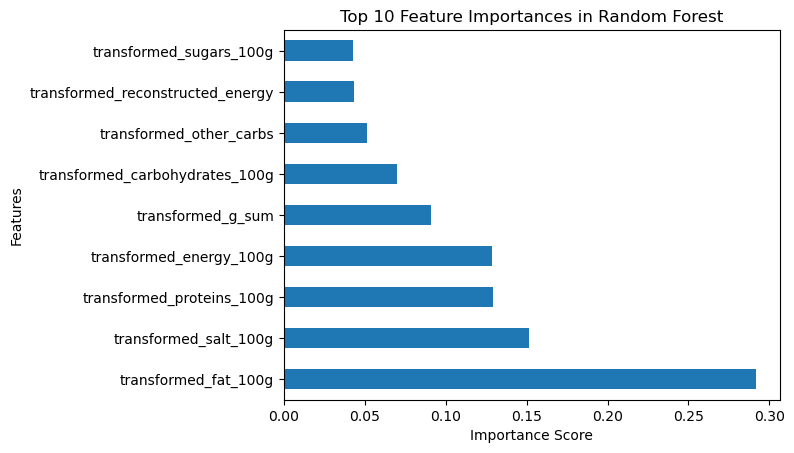

In [158]:
feature_importances = pd.Series(rf.feature_importances_, index=line_X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

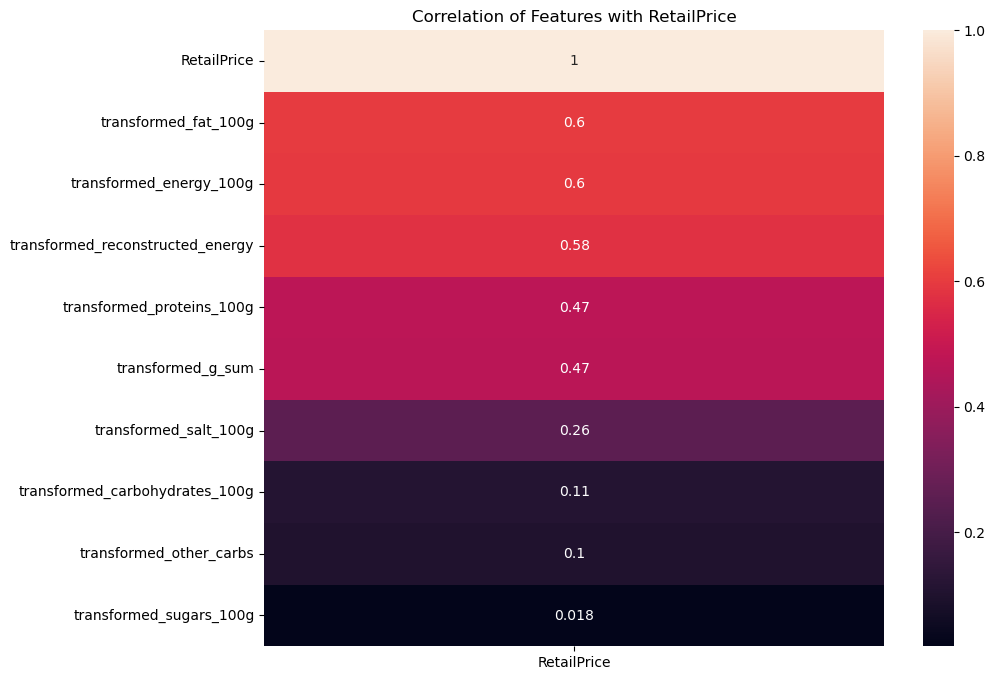

In [159]:
# Correlation matrix
corr_matrix = df_essentials.corr()

# Visualize correlations with the target (RetailPrice)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['RetailPrice']].sort_values(by='RetailPrice', ascending=False), annot=True)
plt.title('Correlation of Features with RetailPrice')
plt.show()

In [160]:

# Select only the numeric features for VIF calculation
#numeric_features = df_cleaned.drop(columns=['RetailPrice', 'product', 'category', 'alternative_category', 'cluster', 'alternative_cluster', 'anomaly'])

# Add a constant to the features matrix for the VIF calculation
variance_IF = df_essentials.assign(constant=1)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = variance_IF.columns
vif['VIF'] = [variance_inflation_factor(variance_IF.values, i) for i in range(variance_IF.shape[1])]

# Show the VIF values
print(vif)

                             Feature         VIF
0     transformed_carbohydrates_100g   39.786989
1               transformed_fat_100g   10.062862
2          transformed_proteins_100g    2.560955
3            transformed_sugars_100g    4.677926
4              transformed_salt_100g    1.858409
5            transformed_other_carbs    5.595568
6            transformed_energy_100g   95.999928
7   transformed_reconstructed_energy  230.609919
8                  transformed_g_sum  136.725746
9                        RetailPrice    1.939766
10                          constant    6.251324


In [211]:

# Drop 'transformed_reconstructed_energy' from the variance_IF DataFrame
variance_IF_work = variance_IF.drop('transformed_reconstructed_energy', axis=1)

# Calculate VIF for each feature in variance_IF_work
vif = pd.DataFrame()
vif['Feature'] = variance_IF_work.columns

# Calculate VIF for each feature
vif['VIF'] = [variance_inflation_factor(variance_IF_work.values, i) for i in range(variance_IF_work.shape[1])]

# Show the VIF values
print(vif)

                          Feature        VIF
0  transformed_carbohydrates_100g  33.768742
1            transformed_fat_100g   8.110308
2       transformed_proteins_100g   2.476152
3         transformed_sugars_100g   4.652232
4           transformed_salt_100g   1.492533
5         transformed_other_carbs   5.594256
6         transformed_energy_100g  39.512456
7               transformed_g_sum  60.228491
8                     RetailPrice   1.936308
9                        constant   6.195081


In [214]:

# Drop 'transformed_reconstructed_energy' from the variance_IF DataFrame
variance_IF_work = variance_IF.drop('transformed_g_sum', axis=1)

# Calculate VIF for each feature in variance_IF_work
vif = pd.DataFrame()
vif['Feature'] = variance_IF_work.columns

# Calculate VIF for each feature
vif['VIF'] = [variance_inflation_factor(variance_IF_work.values, i) for i in range(variance_IF_work.shape[1])]

# Show the VIF values
print(vif)

                            Feature         VIF
0    transformed_carbohydrates_100g   16.779774
1              transformed_fat_100g    8.642572
2         transformed_proteins_100g    2.043087
3           transformed_sugars_100g    4.548612
4             transformed_salt_100g    1.639216
5           transformed_other_carbs    5.371494
6           transformed_energy_100g   92.127514
7  transformed_reconstructed_energy  101.585019
8                       RetailPrice    1.914045
9                          constant    6.210185


In [215]:

# Drop 'transformed_reconstructed_energy' from the variance_IF DataFrame
variance_IF_work = variance_IF.drop('transformed_energy_100g', axis=1)

# Calculate VIF for each feature in variance_IF_work
vif = pd.DataFrame()
vif['Feature'] = variance_IF_work.columns

# Calculate VIF for each feature
vif['VIF'] = [variance_inflation_factor(variance_IF_work.values, i) for i in range(variance_IF_work.shape[1])]

# Show the VIF values
print(vif)

                            Feature         VIF
0    transformed_carbohydrates_100g   39.782993
1              transformed_fat_100g   10.028029
2         transformed_proteins_100g    2.549798
3           transformed_sugars_100g    4.498915
4             transformed_salt_100g    1.764519
5           transformed_other_carbs    5.465431
6  transformed_reconstructed_energy   94.916366
7                 transformed_g_sum  131.210547
8                       RetailPrice    1.878916
9                          constant    6.032364


# Feature Selection and Model Validation

In [161]:
# Create a copy of the features list to avoid modifying the original
reduced_features = features.copy()

# Remove the unwanted features
reduced_features.remove('transformed_sugars_100g')
reduced_features.remove('transformed_reconstructed_energy')

print(reduced_features)

['transformed_carbohydrates_100g', 'transformed_fat_100g', 'transformed_proteins_100g', 'transformed_salt_100g', 'transformed_other_carbs', 'transformed_energy_100g', 'transformed_g_sum']


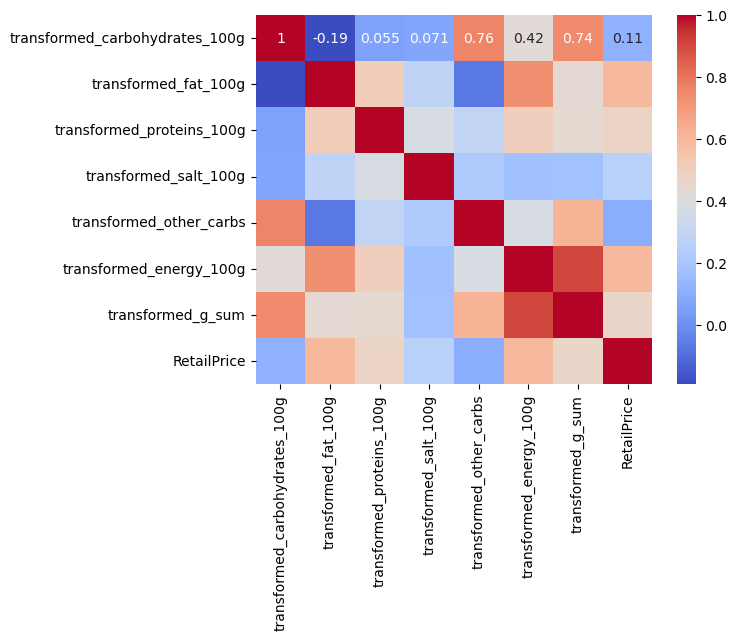

In [162]:
sns.heatmap(df_no_outliers[reduced_features+target].corr(), annot=True, cmap='coolwarm')
plt.show()

Random Forest R-squared: 0.36392973205179613
Linear Regression R-squared: 0.43026604968281645

Random Forest Mean Squared Error: 13.950298154366925
Linear Regression Mean Squared Error: 12.495409510694495


**running linear regression again**

# Alternative Processing 

# Reduced Data

In [163]:
X_reduced = df_no_outliers[reduced_features]
y = df_no_outliers[target]

In [164]:
# Split the data into training and testing sets again
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create and train the linear regression model with the reduced feature set
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train)

# Predicting the test set results
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Evaluating the model performance
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)

print(f"Mean Squared Error (Reduced Features): {mse_reduced}")
print(f"R-squared (Reduced Features): {r2_reduced}")

Mean Squared Error (Reduced Features): 11.850553551899461
R-squared (Reduced Features): 0.4596685540565566


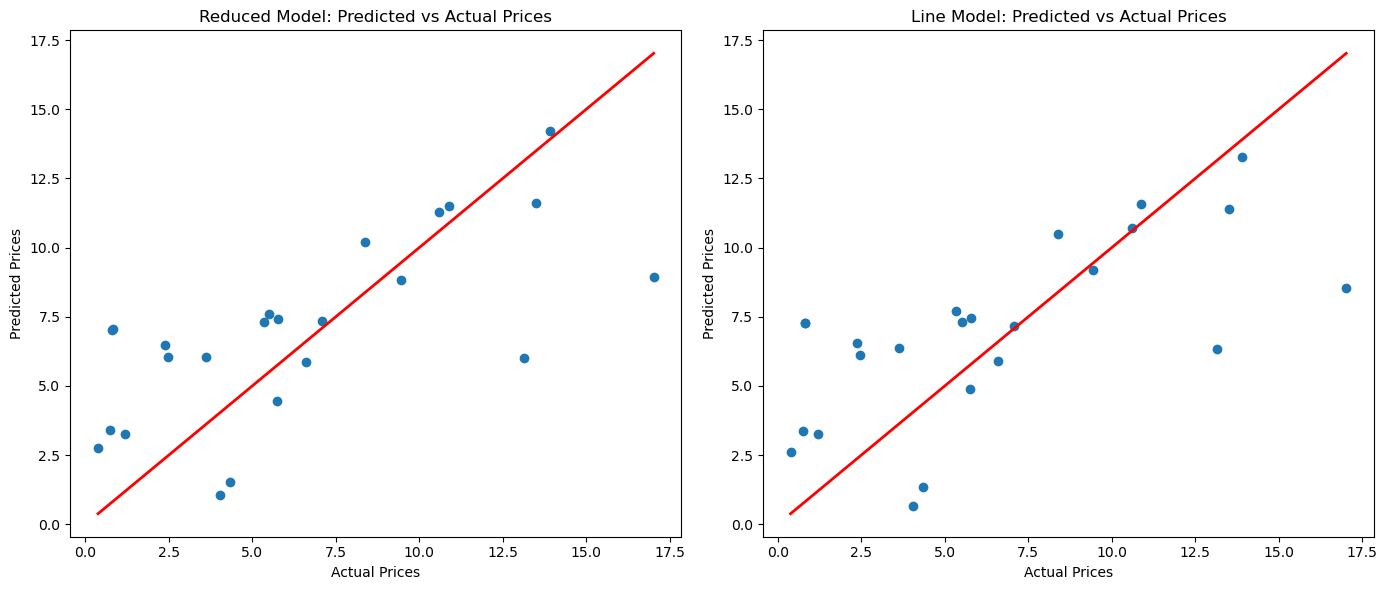

In [165]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First scatter plot: Reduced model
axs[0].scatter(y_test, y_pred_reduced)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
axs[0].set_xlabel('Actual Prices')
axs[0].set_ylabel('Predicted Prices')
axs[0].set_title('Reduced Model: Predicted vs Actual Prices')

# Second scatter plot: Line model
axs[1].scatter(y_test, line_y_pred)
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
axs[1].set_xlabel('Actual Prices')
axs[1].set_ylabel('Predicted Prices')
axs[1].set_title('Line Model: Predicted vs Actual Prices')

# Display the plots
plt.tight_layout()
plt.show()

### Ridge alpha 0.1
#### Test Mean Squared Error: 11.202129853233535
#### Test R-squared: 0.48923373117252333
#### Not part of Readme skip to PCA

Ridge Regularization Helps, but Doesn’t Eliminate the Problem: Ridge regression helps reduce the impact of multicollinearity by shrinking coefficients, but with VIF values as high as these, it’s still difficult for the model to generalize well. This explains why you’re getting a moderate R-squared despite using regularization.

Ridge Regularization Helps, but Doesn’t Eliminate the Problem: Ridge regression helps reduce the impact of multicollinearity by shrinking coefficients, but with VIF values as high as these, it’s still difficult for the model to generalize well. This explains why you’re getting a moderate R-squared despite using regularization.  KFold with shuffle=True and random_state=42: This implementation uses a custom KFold where the data is shuffled before splitting, and random_state=42 ensures reproducibility of the random shuffling. This can lead to different splits each time you run the cross-validation unless random_state is specified.

Single R²: Might overestimate or underestimate performance based on one data split.
	•	Mean Cross-validated R²: Provides a more balanced view of the model’s performance across different data partitions, which is typically more reliable for evaluating real-world performance.

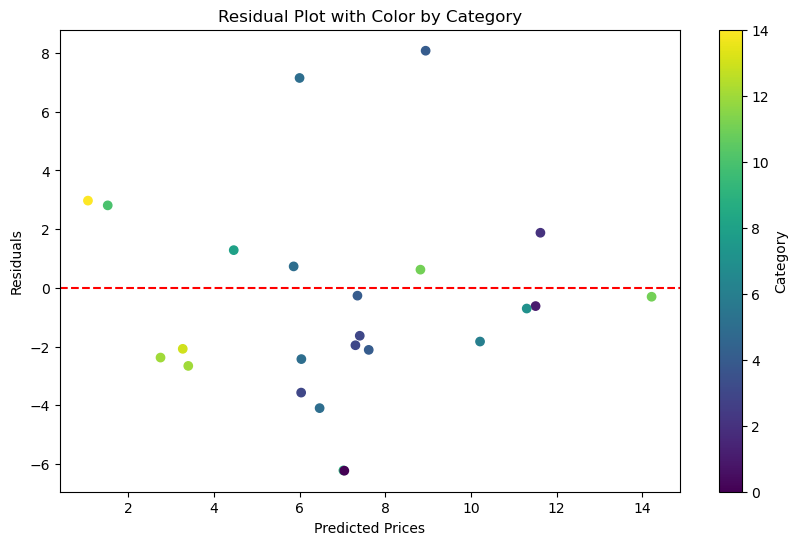

In [166]:
# Calculate residuals
residuals = y_test - y_pred_reduced

# Create residual plot with color-coding based on the 'category' column
plt.figure(figsize=(10, 6))
sc = plt.scatter(y_pred_reduced, residuals, c=df_no_outliers.loc[y_test.index, 'category'].astype('category').cat.codes, cmap='viridis')
plt.colorbar(sc, label='Category')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot with Color by Category')
plt.show()

# Principle Componenet Analysis

In [167]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


	•	Scaling can help reduce the impact of multicollinearity, especially in regularized models like Ridge regression. The improvement in R-squared suggests that the model is now better equipped to handle correlated features, likely because the regularization is being applied more appropriately.


In [168]:
#Use Reduced Data

# Standardizing the data
scaler = StandardScaler()
line_X_scaled = scaler.fit_transform(line_X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retaining components explaining 95% of the variance
line_X_pca = pca.fit_transform(line_X_scaled)

# Check how many components were retained
pca.n_components_

5

In [169]:
# Standardizing the data
scaler = StandardScaler()
line_X_scaled = scaler.fit_transform(line_X)

# Apply PCA to reduce to 5 components
pca = PCA(n_components=5)
line_X_pca = pca.fit_transform(line_X_scaled)

# Check the shape of the transformed data
print("Shape of the data after PCA:", line_X_pca.shape)

Shape of the data after PCA: (118, 5)


In [170]:
# Split the data into training and testing sets to reduced feature set
X_train_pca, X_test_pca, y_train, y_test = train_test_split(line_X_pca, line_y, test_size=0.2, random_state=42)

# Create and train the linear regression model with the reduced feature set
model_reduced = LinearRegression()
model_reduced.fit(X_train_pca, y_train)

# Predicting the test set results
y_pred_pca = model_reduced.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_pca)
r2 = r2_score(y_test, y_pred_pca)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Mean Squared Error: 10.800929008597786
R-squared: 0.5075266684219414


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


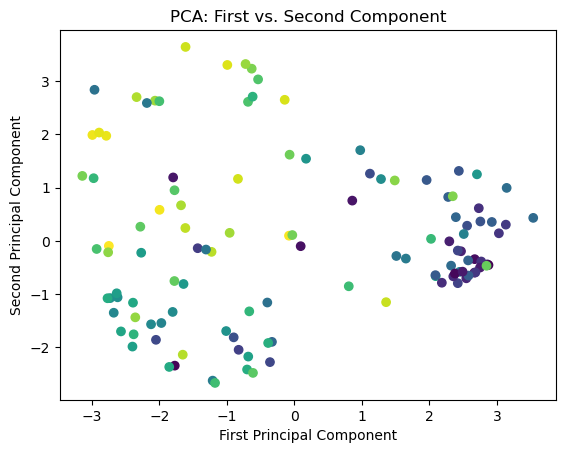

In [171]:
# If 'y' is categorical, you can map it to numeric values for coloring
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Then, use 'y_encoded' for the color argument
plt.scatter(line_X_pca[:, 0], line_X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First vs. Second Component')
plt.show()

In [172]:
print(y)

     RetailPrice
0       2.470300
1       2.953100
2       1.143100
3       2.345800
4       1.197900
..           ...
115     9.884876
116     7.787921
117     1.113668
118    13.149968
119     2.904186

[118 rows x 1 columns]


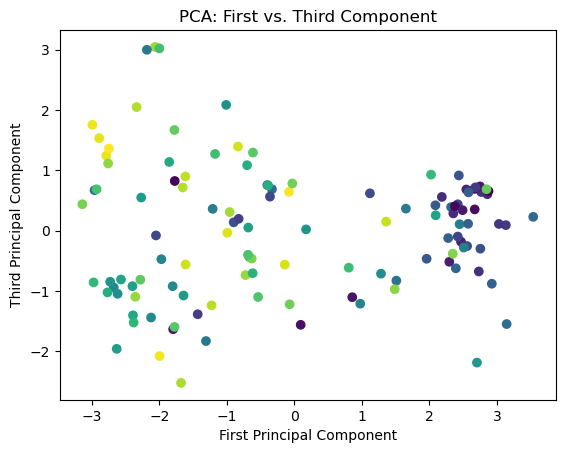

In [173]:
# Plotting the 3rd vs. 1st Principal Components
plt.scatter(line_X_pca[:, 0], line_X_pca[:, 2], c=y_encoded, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Third Principal Component')
plt.title('PCA: First vs. Third Component')
plt.show()

R-squared Improvement:

	•	Linear Regression outperforms Random Forest with an 18.23% improvement in R-squared, indicating that Linear Regression is capturing the variance in the data better.
	•	Ridge Regression shows an even greater improvement over Random Forest, with a 34.82% improvement in R-squared. This suggests that Ridge Regression is handling multicollinearity well and providing a better fit to the data than both Random Forest and Linear Regression.

Mean Squared Error (MSE) Analysis:

	•	Linear Regression has a lower MSE compared to Random Forest, showing a 10.43% improvement. This means that Linear Regression is providing more accurate predictions in terms of minimizing error.
	•	Ridge Regression, however, shows a significant drop in MSE performance when compared to Linear Regression, with an MSE worsening by 96.48%. This suggests that while Ridge improves the R-squared (variance explained), it does so at the cost of increasing error.

# Feature Engineering of Protein to Carbohydrate Ratio

In [174]:
# Create protein-to-carb ratio and drop the original 'proteins_100g' and 'carbohydrates_100g' columns if needed
df_with_eng_feature = df_no_outliers.assign(
    protein_to_carb_ratio=df_no_outliers['proteins_100g'] / df_no_outliers['carbohydrates_100g']
).replace([np.inf, -np.inf], np.nan).fillna(0).drop(columns=['proteins_100g', 'carbohydrates_100g'])

eng_f = ['transformed_carbohydrates_100g']

In [175]:
df_with_eng_feature.head()

,product,RetailPrice,energy_100g,fat_100g,sugars_100g,salt_100g,g_sum,other_carbs,reconstructed_energy,boxcox_carbohydrates_100g,...,transformed_reconstructed_energy,boxcox_g_sum,transformed_g_sum,cluster,category,certainty,alternative_cluster,alternative_category,anomaly,protein_to_carb_ratio
0,Artichoke,2.4703,314.0,6.67,1.67,0.76200,12.0,1.66,331.79,-0.877858,...,-1.033042,-0.290163,-1.195525,4,creams & dips,1.0000,6,strange cluster 6,0,0.501502
1,Asparagus,2.9531,222.0,3.53,1.18,0.14986,10.0,2.35,230.57,-0.865997,...,-1.207215,-0.381893,-1.241809,4,creams & dips,0.6441,18,tomato sauce,0,0.665722
2,Beets,1.1431,167.0,0.00,2.00,0.12700,12.0,8.00,204.00,-0.504974,...,-1.254806,-0.290163,-1.195525,18,tomato sauce,0.9965,1,beans & peas,0,0.200000
3,Broccoli,2.3458,121.0,0.00,2.35,0.07366,8.0,2.36,140.08,-0.797202,...,-1.373130,-0.470604,-1.286569,18,tomato sauce,1.0000,8,yoghurt and milk,0,0.749469
4,Carrots,1.1979,159.0,0.00,6.41,0.19558,10.0,2.56,174.25,-0.560350,...,-1.309162,-0.381893,-1.241809,18,tomato sauce,0.9999,8,yoghurt and milk,0,0.142698


# Additional Processing

# Extended Feature Engineering

# Feature Selection

Correlation Matrix:
                                   transformed_carbohydrates_100g  \
transformed_carbohydrates_100g                          1.000000   
transformed_fat_100g                                   -0.192843   
transformed_proteins_100g                               0.049109   
transformed_sugars_100g                                 0.705840   
transformed_salt_100g                                   0.067773   
transformed_other_carbs                                 0.753766   
transformed_energy_100g                                 0.415267   
transformed_reconstructed_energy                        0.436267   
transformed_g_sum                                       0.735648   

                                  transformed_fat_100g  \
transformed_carbohydrates_100g               -0.192843   
transformed_fat_100g                          1.000000   
transformed_proteins_100g                     0.528445   
transformed_sugars_100g                      -0.277404   
transfor

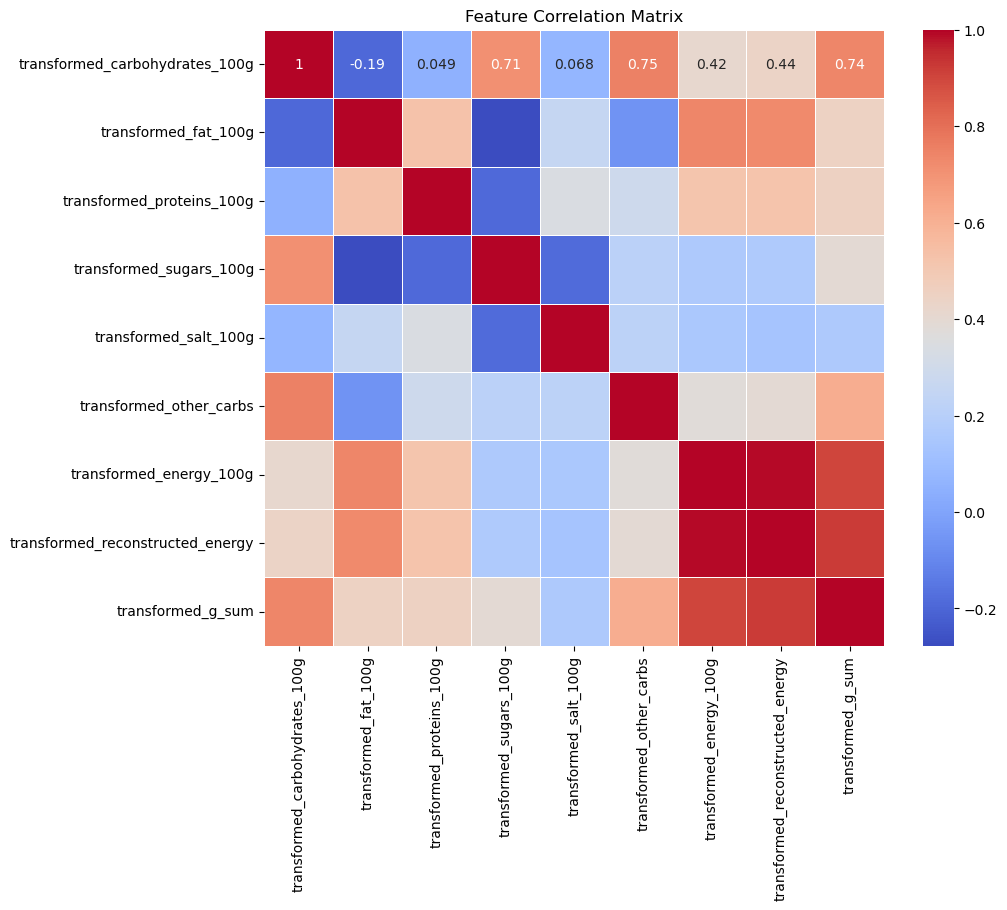

In [192]:
# Calculate the correlation matrix
corr_matrix = df[[
    'transformed_carbohydrates_100g', 
    'transformed_fat_100g', 
    'transformed_proteins_100g', 
    'transformed_sugars_100g', 
    'transformed_salt_100g', 
    'transformed_other_carbs', 
    'transformed_energy_100g', 
    'transformed_reconstructed_energy', 
    'transformed_g_sum'
]].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", corr_matrix)

# Optionally visualize the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

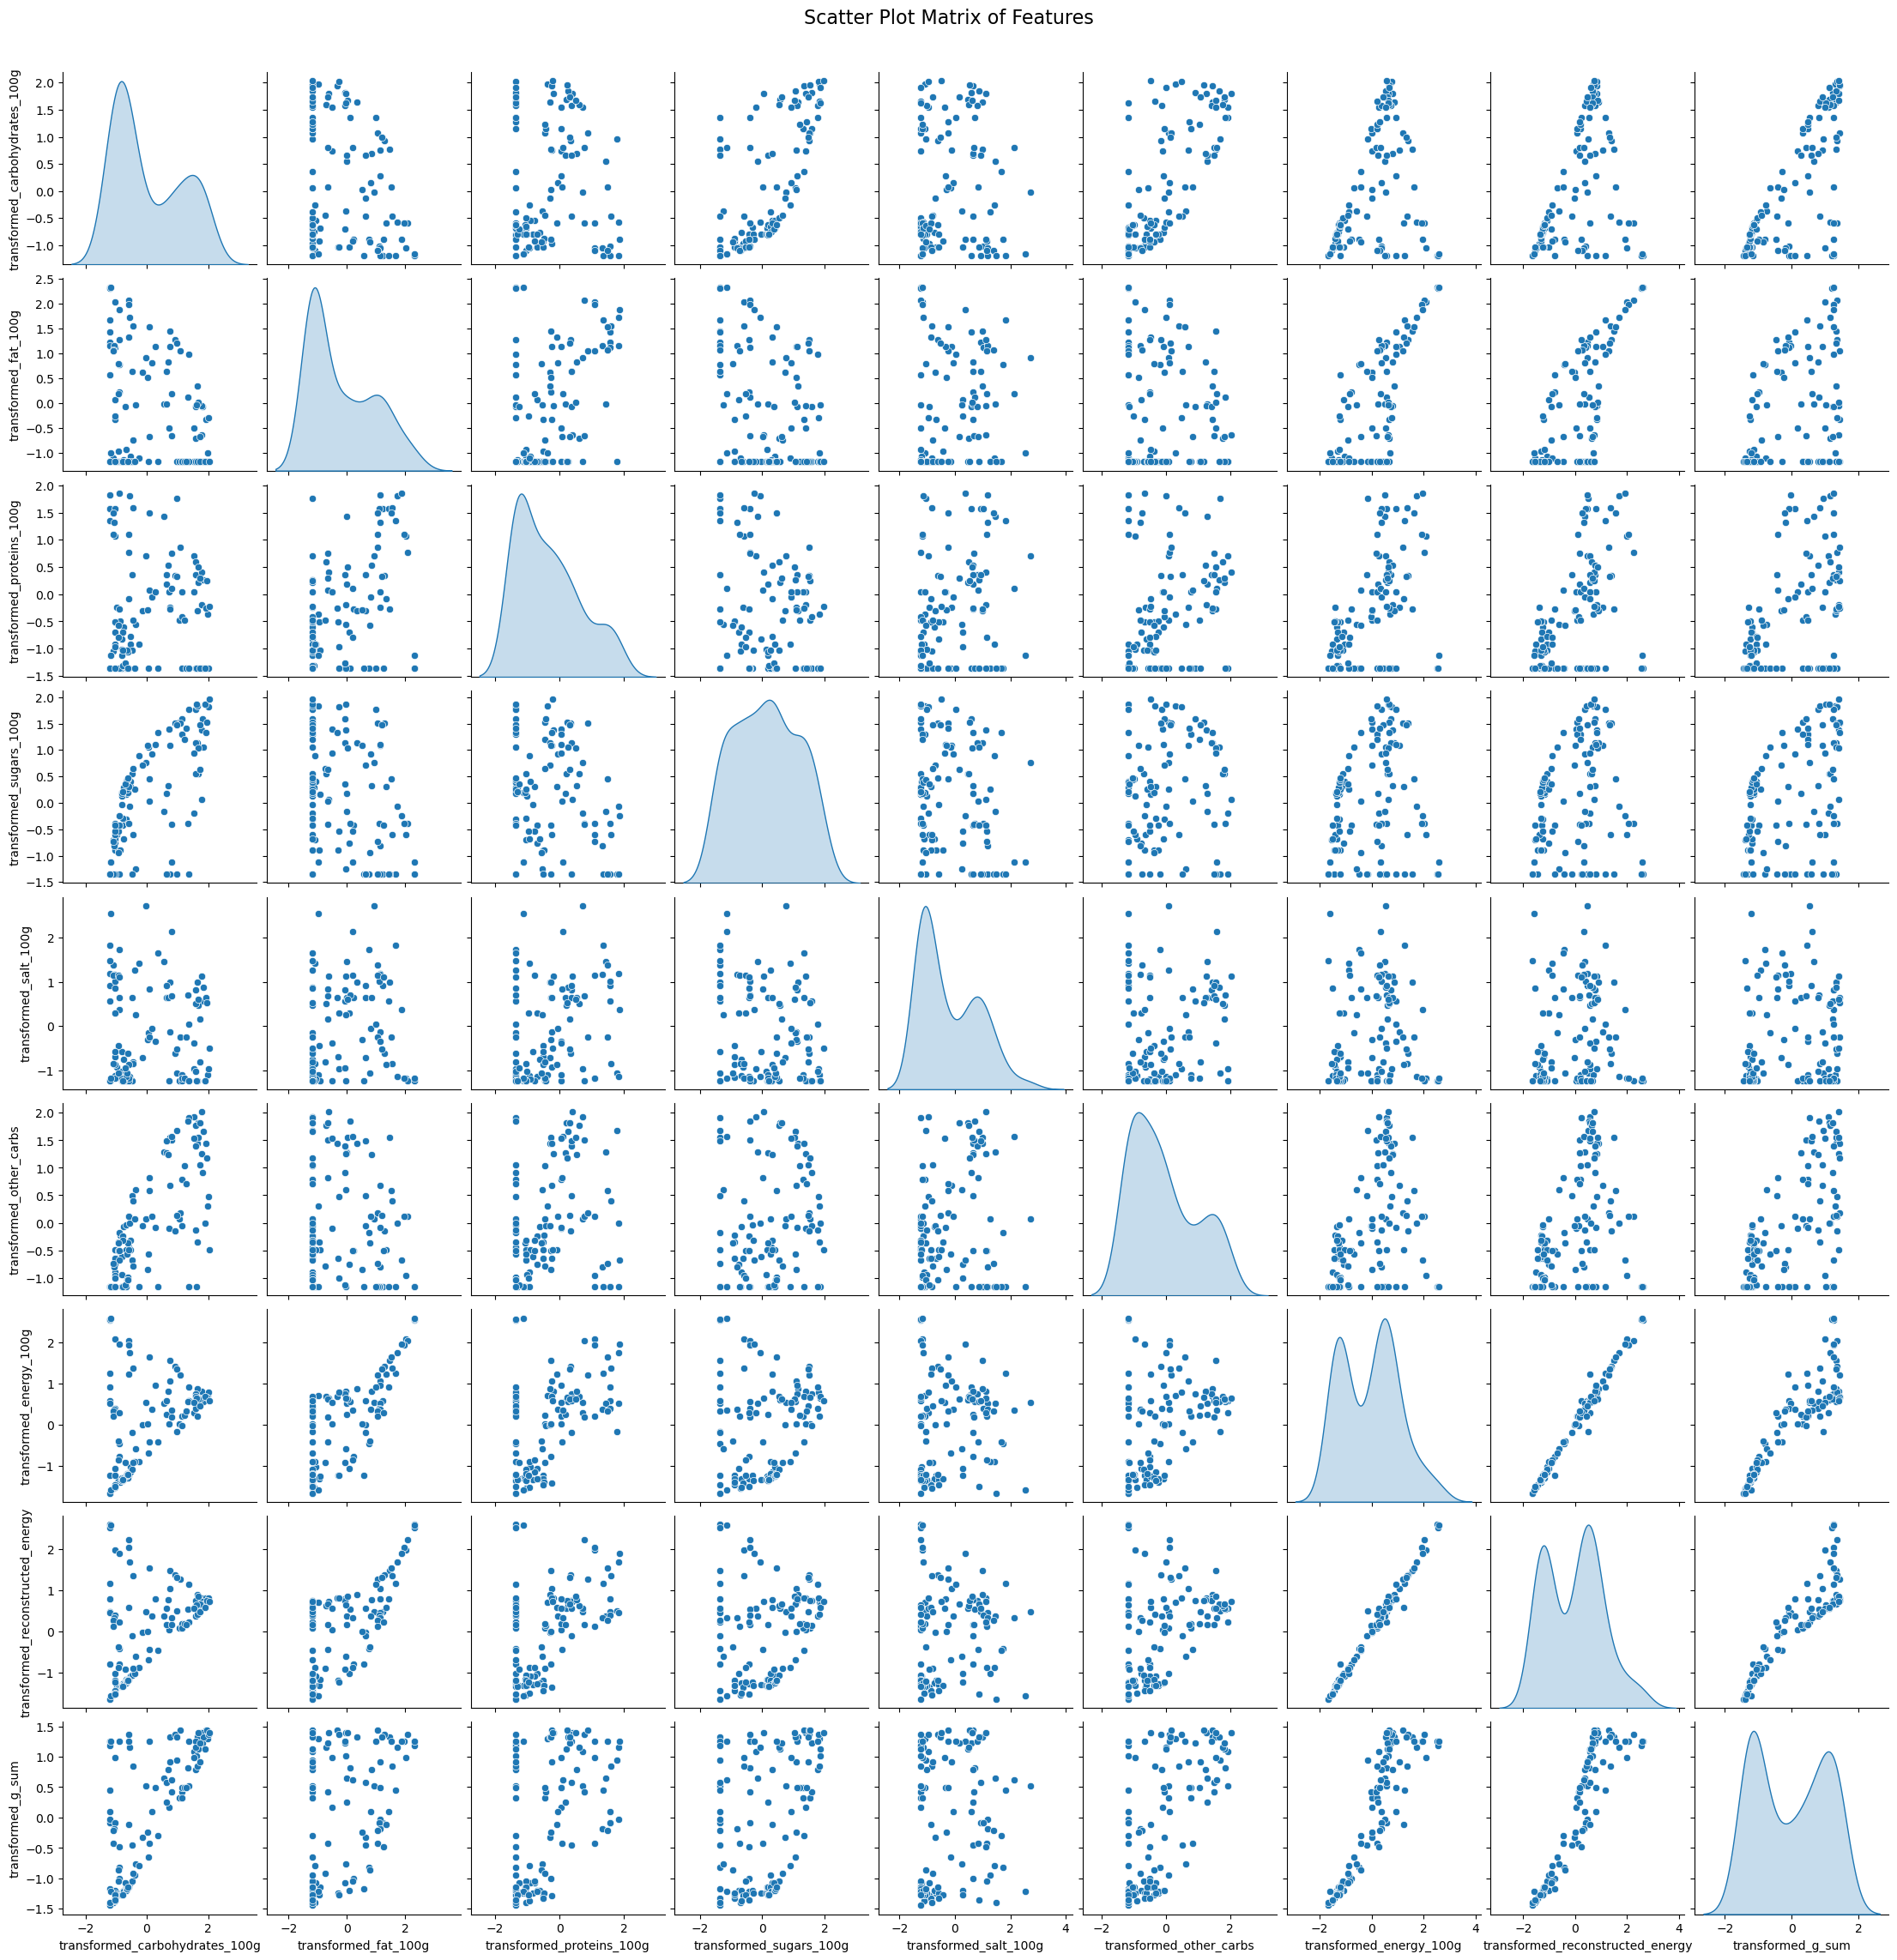

In [193]:
# Create a pairplot (scatter plot matrix) for the features
sns.pairplot(df[[
    'transformed_carbohydrates_100g', 
    'transformed_fat_100g', 
    'transformed_proteins_100g', 
    'transformed_sugars_100g', 
    'transformed_salt_100g', 
    'transformed_other_carbs', 
    'transformed_energy_100g', 
    'transformed_reconstructed_energy', 
    'transformed_g_sum'
]], diag_kind='kde')

plt.suptitle("Scatter Plot Matrix of Features", y=1.02, size=16)
plt.show()

# Feature Integration

In [176]:
X_eng = df_with_eng_feature[reduced_features + eng_f]
y_eng = df_with_eng_feature[target]

In [177]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

In [178]:
# Create and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
line_y_pred = linear_model.predict(X_test)

# Calculate performance metrics
line_mse = mean_squared_error(y_test, line_y_pred)
line_r2 = r2_score(y_test, line_y_pred)

print("Mean Squared Error:", line_mse)
print("R-squared:", line_r2)


Mean Squared Error: 11.850553551899438
R-squared: 0.4596685540565577


In [179]:
# Create and train the linear regression model (already done)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 1. Make predictions on the test set (already done)
line_y_pred_test = linear_model.predict(X_test)

# 2. Make predictions on the training set
line_y_pred_train = linear_model.predict(X_train)

# 3. Calculate performance metrics for the test set
line_test_mse = mean_squared_error(y_test, line_y_pred_test)
line_test_r2 = r2_score(y_test, line_y_pred_test)

# 4. Calculate performance metrics for the training set
line_train_mse = mean_squared_error(y_train, line_y_pred_train)
line_train_r2 = r2_score(y_train, line_y_pred_train)

# 5. Print performance metrics
print("Test Set Performance:")
print(f"Mean Squared Error (Test): {line_test_mse}")
print(f"R-squared (Test): {line_test_r2}")

print("\nTraining Set Performance:")
print(f"Mean Squared Error (Train): {line_train_mse}")
print(f"R-squared (Train): {line_train_r2}")

Test Set Performance:
Mean Squared Error (Test): 11.850553551899438
R-squared (Test): 0.4596685540565577

Training Set Performance:
Mean Squared Error (Train): 10.369893741854172
R-squared (Train): 0.4725794249144787


Results show that the model is neither underfitted or overfitted.  Generally, just poorly fit.

# PCA

In [180]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [181]:
#Use Reduced Data

# Standardizing the data
scaler = StandardScaler()
line_X_scaled = scaler.fit_transform(X_eng)

# Apply PCA
pca = PCA(n_components=0.95)  # Retaining components explaining 95% of the variance
line_X_pca = pca.fit_transform(line_X_scaled)

# Check how many components were retained
pca.n_components_

4

In [182]:
# Standardizing the data
scaler = StandardScaler()
line_X_scaled = scaler.fit_transform(X_eng)

# Apply PCA to reduce to 5 components
pca = PCA(n_components=5)
line_X_pca = pca.fit_transform(line_X_scaled)

# Check the shape of the transformed data
print("Shape of the data after PCA:", line_X_pca.shape)

Shape of the data after PCA: (118, 5)


In [183]:
# Split the data into training and testing sets to reduced feature set
X_train_pca, X_test_pca, y_train, y_test = train_test_split(line_X_pca, y_eng, test_size=0.2, random_state=42)

# Create and train the linear regression model with the reduced feature set
model_reduced = LinearRegression()
model_reduced.fit(X_train_pca, y_train)

# Predicting the test set results
y_pred_pca = model_reduced.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_pca)
r2 = r2_score(y_test, y_pred_pca)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Mean Squared Error: 11.077177568030576
R-squared: 0.49493098815228953


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


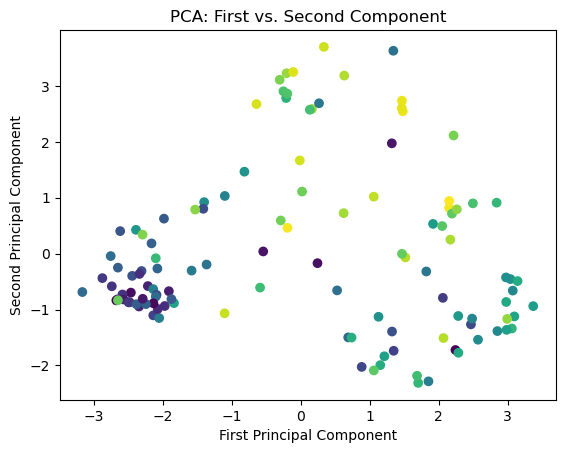

In [184]:
# If 'y' is categorical, you can map it to numeric values for coloring
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Then, use 'y_encoded' for the color argument
plt.scatter(line_X_pca[:, 0], line_X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First vs. Second Component')
plt.show()

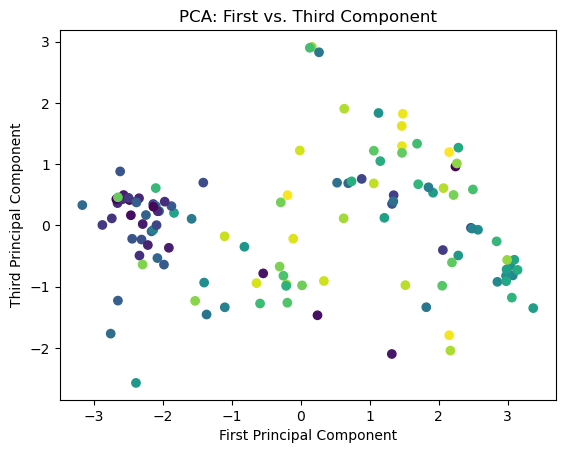

In [185]:
# Plotting the 3rd vs. 1st Principal Components
plt.scatter(line_X_pca[:, 0], line_X_pca[:, 2], c=y_encoded, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Third Principal Component')
plt.title('PCA: First vs. Third Component')
plt.show()